# Predicción de Vacunación con XGBoost

## Introducción

En este notebook, implementaremos un modelo basado en XGBoost para predecir la probabilidad de vacunación contra H1N1 y vacunas estacionales. Usaremos BayesSearchCV para la optimización de hiperparámetros y realizaremos un análisis detallado de las métricas del modelo.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import joblib
import os

## 1. Carga de datos

Comenzamos cargando los dataset preprocesados tras la división hecha por train_test_split. Contienen las características y las variables objetivo: h1n1_vaccine y seasonal_vaccine.

In [3]:
X_train = pd.read_csv("../../Data/preprocessed_X_train.csv", index_col="respondent_id")
X_test = pd.read_csv("../../Data/preprocessed_X_test.csv", index_col="respondent_id")
y_train = pd.read_csv("../../Data/preprocessed_y_train.csv", index_col="respondent_id")
y_test = pd.read_csv("../../Data/preprocessed_y_test.csv", index_col="respondent_id")

## 2. Entrenamiento y optimización de hiperparámetros

In [4]:
# Espacio de búsqueda de hiperparámetros
search_space = {
    'estimator__max_depth': Integer(3, 20),  # Aumentar profundidad máxima del árbol
    'estimator__learning_rate': Real(0.001, 0.3, prior='log-uniform'),  # Ampliar rango del learning rate
    'estimator__subsample': Real(0.3, 1.0),  # Permitir tamaños de muestra más pequeños
    'estimator__colsample_bytree': Real(0.3, 1.0),  # Más flexibilidad en columnas seleccionadas
    'estimator__n_estimators': Integer(50, 500),  # Incrementar número máximo de árboles
    'estimator__gamma': Real(0.0, 10.0),  # Permitir mayor regularización
    'estimator__min_child_weight': Integer(1, 10),  # Considerar pesos mínimos para evitar sobreajuste
    'estimator__reg_alpha': Real(0.0, 1.0),  # Regularización L1
    'estimator__reg_lambda': Real(0.0, 1.0)  # Regularización L2
}

# Crear el modelo base
xgb_model = XGBClassifier(eval_metric='auc', random_state=42)

# Envolverlo en MultiOutputClassifier para predicción multietiqueta
multi_xgb = MultiOutputClassifier(xgb_model)

In [5]:
# Configurar BayesSearchCV
opt = BayesSearchCV(
    multi_xgb,
    search_space,
    cv=5,
    n_iter=50,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1
)

# Entrenar el modelo con optimización
opt.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros
print("Mejores hiperparámetros:", opt.best_params_)
print("Mejor puntaje (AUROC):", opt.best_score_)

Mejores hiperparámetros: OrderedDict({'estimator__colsample_bytree': 1.0, 'estimator__gamma': 5.298302625766743, 'estimator__learning_rate': 0.03264820543291535, 'estimator__max_depth': 10, 'estimator__min_child_weight': 1, 'estimator__n_estimators': 403, 'estimator__reg_alpha': 0.941380446393215, 'estimator__reg_lambda': 1.0, 'estimator__subsample': 0.459940784457817})
Mejor puntaje (AUROC): 0.8654716138821849


## 3. Evaluar el modelo

Calculamos métricas de rendimiento clave, como precisión, recall, F1-score y nuestra métrica principal AUROC para ambas etiquetas.

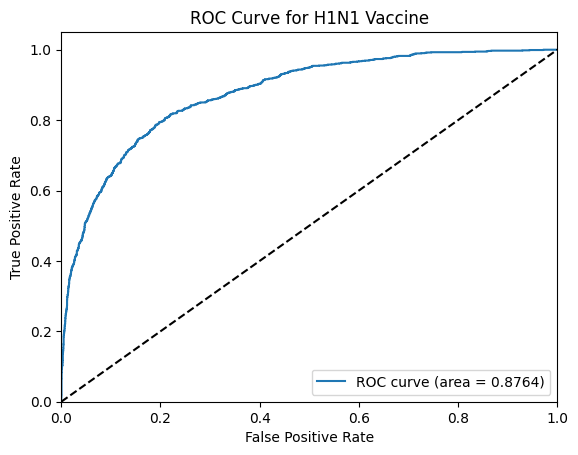

In [6]:
# Predicciones y probabilidades
y_pred = opt.best_estimator_.predict(X_test)
y_proba = opt.best_estimator_.predict_proba(X_test)

# Evaluación para H1N1
h1n1_probabilities = y_proba[0][:, 1]
h1n1_predictions = y_pred[:, 0]
roc_auc_h1n1 = roc_auc_score(y_test['h1n1_vaccine'], h1n1_probabilities)
accuracy_h1n1 = accuracy_score(y_test['h1n1_vaccine'], h1n1_predictions)

# Curva ROC para H1N1
fpr_h1n1, tpr_h1n1, _ = roc_curve(y_test['h1n1_vaccine'], h1n1_probabilities)
plt.figure()
plt.plot(fpr_h1n1, tpr_h1n1, label=f'ROC curve (area = {roc_auc_h1n1:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for H1N1 Vaccine')
plt.legend(loc="lower right")
plt.show()

In [7]:
print(f"AUROC para H1N1: {roc_auc_h1n1}")
print(f"Accuracy para H1N1: {accuracy_h1n1}")

AUROC para H1N1: 0.8763800420737831
Accuracy para H1N1: 0.8558592287532759


In [8]:
# Generar y mostrar el classification report para H1N1
print("Classification Report for H1N1 Vaccine:")
print(classification_report(y_test['h1n1_vaccine'], h1n1_predictions, target_names=["No", "Yes"]))

Classification Report for H1N1 Vaccine:
              precision    recall  f1-score   support

          No       0.88      0.95      0.91      4207
         Yes       0.72      0.52      0.61      1135

    accuracy                           0.86      5342
   macro avg       0.80      0.73      0.76      5342
weighted avg       0.85      0.86      0.85      5342



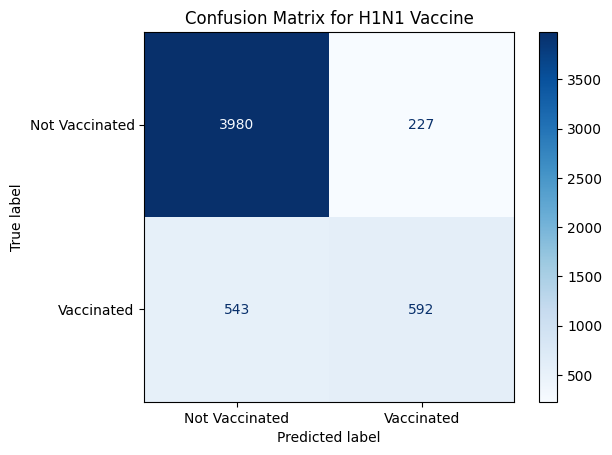

In [9]:
# Matriz de confusión del modelo
conf_matrix= confusion_matrix(y_test['h1n1_vaccine'], h1n1_predictions)
disp= ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Not Vaccinated', 'Vaccinated'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for H1N1 Vaccine")
plt.show()

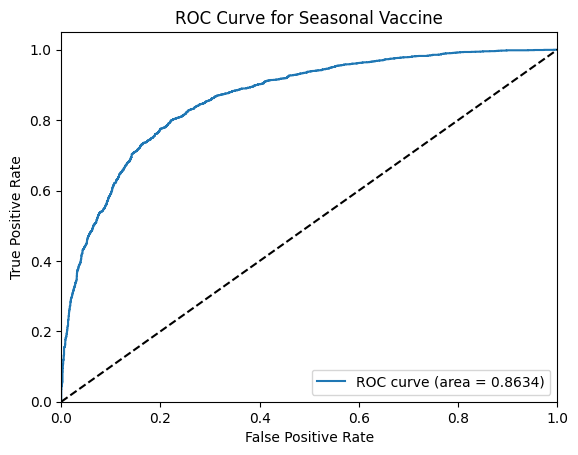

In [10]:
# Evaluación para Vacuna Estacional
seasonal_probabilities = y_proba[1][:, 1]
seasonal_predictions = y_pred[:, 1]
roc_auc_seasonal = roc_auc_score(y_test['seasonal_vaccine'], seasonal_probabilities)
accuracy_seasonal = accuracy_score(y_test['seasonal_vaccine'], seasonal_predictions)

# Curva ROC para Vacuna Estacional
fpr_seasonal, tpr_seasonal, _ = roc_curve(y_test['seasonal_vaccine'], seasonal_probabilities)
plt.figure()
plt.plot(fpr_seasonal, tpr_seasonal, label=f'ROC curve (area = {roc_auc_seasonal:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Seasonal Vaccine')
plt.legend(loc="lower right")
plt.show()

In [11]:
print(f"AUROC para Vacuna Estacional: {roc_auc_seasonal}")
print(f"Accuracy para Vacuna Estacional: {accuracy_seasonal}")

AUROC para Vacuna Estacional: 0.8634432662906689
Accuracy para Vacuna Estacional: 0.7865967802321228


In [12]:
# Generar y mostrar el classification report para seasonal
print("Classification Report for seasonal Vaccine:")
print(classification_report(y_test['seasonal_vaccine'], seasonal_predictions, target_names=["No", "Yes"]))

Classification Report for seasonal Vaccine:
              precision    recall  f1-score   support

          No       0.80      0.81      0.80      2854
         Yes       0.78      0.76      0.77      2488

    accuracy                           0.79      5342
   macro avg       0.79      0.78      0.79      5342
weighted avg       0.79      0.79      0.79      5342



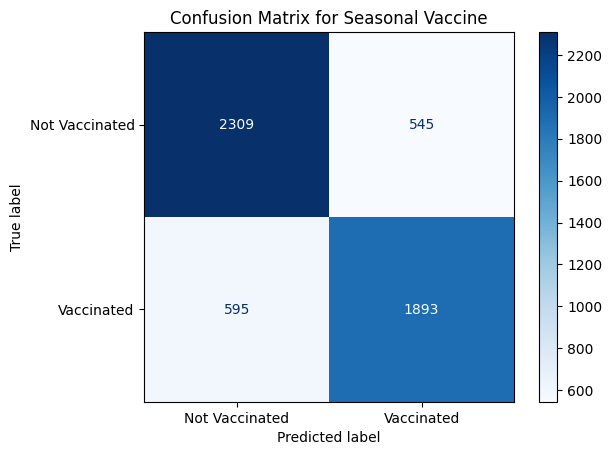

In [17]:
# Matriz de confusión para Vacuna Estacional
conf_matrix_seasonal = confusion_matrix(y_test['seasonal_vaccine'], seasonal_predictions)
disp_seasonal = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_seasonal, display_labels=['Not Vaccinated', 'Vaccinated'])
disp_seasonal.plot(cmap='Blues')
plt.title("Confusion Matrix for Seasonal Vaccine")
plt.show()

## 4. Guardar el modelo

Si el modelo supera las métricas del modelo anterior lo guardamos para tener el mejor modelo siempre guardado.

In [14]:
def save_model_if_better(model, current_roc_auc, model_path, metric_path):

    # Cargar la métrica del modelo previo si existe
    if os.path.exists(metric_path):
        with open(metric_path, "r") as f:
            best_roc_auc = float(f.read().strip())
    else:
        best_roc_auc = 0.0
    
    print(f"Current ROC AUC: {current_roc_auc:.4f} | Best ROC AUC: {best_roc_auc:.4f}")

    # Comparar y guardar el modelo si mejora
    if current_roc_auc > best_roc_auc:
        print("El modelo es mejor que el anterior...")
        joblib.dump(model, model_path)  # Guardar el modelo
        with open(metric_path, "w") as f:
            f.write(f"{current_roc_auc:.4f}")  # Guardar la métrica actual
    else:
        print("El modelo no es mejor que el anterior. Saltando el guardado.")

In [15]:
current_roc_auc = (roc_auc_seasonal + roc_auc_h1n1) / 2
model_path = "Modelos/XGBoost_best_model.pkl"
metric_path = "Modelos/XGBoost_best_roc_auc.txt"
save_model_if_better(opt.best_estimator_, current_roc_auc, model_path, metric_path)

Current ROC AUC: 0.8699 | Best ROC AUC: 0.8699
El modelo es mejor que el anterior...


## 5. Generar el archivo de envío a la competición

Para generar el archivo de envío, aplicamos el modelo al dataset de prueba y creamos un archivo .csv con las predicciones.

In [16]:
# Cargar el dataset de prueba preprocesado
test_set_preprocessed = pd.read_csv("../../Data/preprocessed_test_set_features.csv")

# Asegurarse de que respondent_id esté disponible
respondent_ids = test_set_preprocessed['respondent_id']

# Eliminar respondent_id del conjunto de características
X_test_final = test_set_preprocessed.drop(columns=['respondent_id'])

# Realizar predicciones de probabilidad
y_proba_test = opt.best_estimator_.predict_proba(X_test_final)

# Extraer las probabilidades para la clase positiva (1)
y_proba_h1n1_test = y_proba_test[0][:, 1]  # Probabilidades para H1N1
y_proba_seasonal_test = y_proba_test[1][:, 1]  # Probabilidades para vacuna estacional

# Crear el DataFrame de submission
submission = pd.DataFrame({
    "respondent_id": respondent_ids,
    "h1n1_vaccine": y_proba_h1n1_test,
    "seasonal_vaccine": y_proba_seasonal_test
})

# Guardar el archivo de submission
submission.to_csv("Submissions/XGBoost_submission.csv", index=False)
print("Archivo 'XGBoost_submission.csv' generado correctamente.")

Archivo 'XGBoost_submission.csv' generado correctamente.
